In [1]:
# Ideas for improvement
# Store the player alongside with the board state, as the move heuristics should depend on the currently active player
# Don't store the actions in a node, calculating them is quick and we are memory bound
# Rotate or reflect the board when feeding it to a neural net - tak is rotation/reflection-invariant

In [1]:
include("src/TakEnv.jl")
include("src/Encoder.jl")
include("src/MCTS.jl")
include("src/Model.jl")

Main.Model

In [2]:
using .TakEnv
using .TakEnv: black, white
using .Encoder
using .MCTS
using .Model
using StatProfilerHTML
using BenchmarkTools
using Distributions
using StatsBase
using Flux

Float = Float32

Float32

In [3]:

function play_game(hparams, storage::MCTSStorage, model)
    buf, res, storages = play_game(hparams, (storage, storage), (model, model))
    buf, res, storages[1]
end

function play_game(hparams, storages::NTuple{2, MCTSStorage}, models::NTuple{2, Any})
    board = empty_board()
    cur_player = white::Player
    first_player = white::Player
    history = []
    
    result = nothing
    first_player_result = nothing
    # Play a game
    while isnothing(result)
        storage_idx = cur_player==first_player ? 1 : 2
        
        # Perform a bit of MCTS and then choose an action
        possible_actions = compress_action.(enumerate_actions(board, cur_player))
        state = compress_board(board)
        storage = mcts_search(hparams, storages[storage_idx], state, cur_player, models[storage_idx])
        tau = hparams["steps_before_tau_0"] > length(history) ? hparams["tau"] : 0
        probs, avg_val, actions = evaluate_node(storages[storage_idx], state, tau, possible_actions)
        action_idx = sample(1:length(actions), AnalyticWeights(probs))
        push!(history, (state, cur_player, probs, actions))
        
        # Advance the game-state and check for a win
        apply_action!(board, decompress_action(actions[action_idx]), cur_player)
        result = check_win(board, cur_player)
        if !isnothing(result)
            if result[1] == TakEnv.draw
                result = 0
                first_player_result = 0
            elseif result[2] == first_player
                result = 1
                first_player_result = 1
            else
                result = 1
                first_player_result = -1
            end
            break
        end
        cur_player = opponent_player(cur_player)
        #println("Step $(length(history)) with value $(avg_val[action_idx])")
    end
    
    # Create the replay buffer by backing up the result
    replay_buffer = []
    for (state, player, probs, actions) in reverse(history)
        push!(replay_buffer, (state, player, probs, actions, result))
        result = -result
    end
    
    replay_buffer, first_player_result, storages
end

play_game (generic function with 2 methods)

In [15]:
function play_tournament(hparams, models::NTuple{2, Any})
    results = [0, 0]
    
    fake_hparams = deepcopy(hparams)
    fake_hparams["tau"] = 0
    
    models_bound = map(model -> (states, players)->run_batch(model, states, players), models)

    
    for i in 1:hparams["tournament_rounds"]
        _, r, _ = play_game(fake_hparams, (MCTSStorage(), MCTSStorage()), i%2 == 0 ? models_bound : reverse(models_bound))
        
        if r > 0 && i%2 == 0 || r < 0 && i%2 != 0
            results[1] += 1
        elseif r > 0 && i%2 == 0 || r < 0 && i%2 == 0 
            results[2] += 1
        end
    end
    results
end

play_tournament (generic function with 1 method)

In [14]:
function train_loop(hparams)
    model = construct_model(hparams)
    target_model = deepcopy(model)
    run_batch_bound = (states, players)->run_batch(target_model, states, players)

    storage = MCTSStorage()
    replay_buffer = []
    exchange_count = 0
    
    println("Starting self-play")
    for epoch in 1:hparams["epochs"]
        start = time_ns()
        local_replay, res, storage = play_game(hparams, storage, run_batch_bound)
        replay_buffer = vcat(replay_buffer, local_replay)
        
        postgame = time_ns()
        
        if length(replay_buffer) < hparams["min_replay_buffer_length"]
            println("Still warming up, currently $(length(replay_buffer)) items in the buffer ($(length(local_replay)/(postgame-start)*1e9)it/s)")
            continue
        end
        
        valueloss, probloss = Model.train!(hparams, model, replay_buffer)
        
        posttrain = time_ns()
        
        println("Epoch $(epoch), V-loss: $(valueloss), P-loss: $(probloss), Play-time: $((postgame-start)*1e9)s Train-time: $((posttrain-postgame)*1e9)s")
        
        
        if epoch>0 && epoch%hparams["play_tournament_every"]==0
            println("Playing tournament...")
            res = play_tournament(hparams, (model, target_model))
            
            # Check if we have to exchange the model
            if res[1] > sum(res)*hparams["model_exchange_threshold"]
                println("Model tournament won, exchanging model $(exchange_count) and checkpointing")
                replay_buffer = []
                storage = MCTSStorage()
                target_model = deepcopy(model)
                run_batch_bound = (states, players)->run_batch(target_model, states, players)
                exchange_count += 1
                save_model("model_$(exchange_count).bson", model)
            end
        end
    end
    
end

train_loop (generic function with 1 method)

In [19]:
hparams = Dict(
    "d_puct" => 1.0,
    "mcts_batch_size" => 16,
    "mcts_iterations" => 10,
    "run_name" => "testrun",
    "exploration_factor" => 0.25,
    "hidden_size" => 2048,
     # Tak has a white-bias (meaning the starting player is 60% more likely to win) - 
    # starting player randomization could balance this out
    "randomize_starting_player" => false,
    # How strong it should add random to move selection (0 -> fully greedy, inf -> fully random)
    "tau" => 1.0,
    # How many steps to apply above tau before switching to fully greedy
    "steps_before_tau_0" => 8,
    # How long to self-play before doing a training run
    "min_replay_buffer_length" => 50,
    # How many rounds of training per game
    "train_rounds" => 10,
    # Training batch size
    "train_batch_size" => 256,
    "epochs" => 1000,
    # How many rounds to play a tournament
    "tournament_rounds" => 10,
    # Every x epochs to play a tournament
    "play_tournament_every" => 2,
    # The threshold which results in model exchange
    # In fraction of games won
    "model_exchange_threshold" => 0.6
  )

train_loop(hparams)

Constructing model: (925, 2) -> 2048 -> (3175, 1)
Starting self-play
Epoch 1, V-loss: 1.0274144, P-loss: 7.9350944, Play-time: 4.4893260154e19s Train-time: 1.7189357357e19s
Epoch 2, V-loss: 1.0049455, P-loss: 7.728598, Play-time: 1.4105034167e19s Train-time: 1.5543752872e19s
Playing tournament...


LoadError: InterruptException:

In [21]:
board = random_game(20)[1]

5×5×43 Array{Union{Nothing, Tuple{Stone,Player}},3}:
[:, :, 1] =
 nothing         (stand, black)  nothing        (stand, white)  nothing
 (flat, white)   nothing         nothing        (stand, white)  (flat, black)
 (stand, white)  (flat, white)   nothing        nothing         nothing
 nothing         nothing         (flat, black)  (flat, black)   (flat, white)
 (flat, black)   (flat, black)   (cap, black)   nothing         (cap, white)

[:, :, 2] =
 nothing  nothing         nothing  nothing        nothing
 nothing  nothing         nothing  nothing        nothing
 nothing  (stand, white)  nothing  nothing        nothing
 nothing  nothing         nothing  (flat, black)  nothing
 nothing  nothing         nothing  nothing        nothing

[:, :, 3] =
 nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing

...

[:, :, 41] 

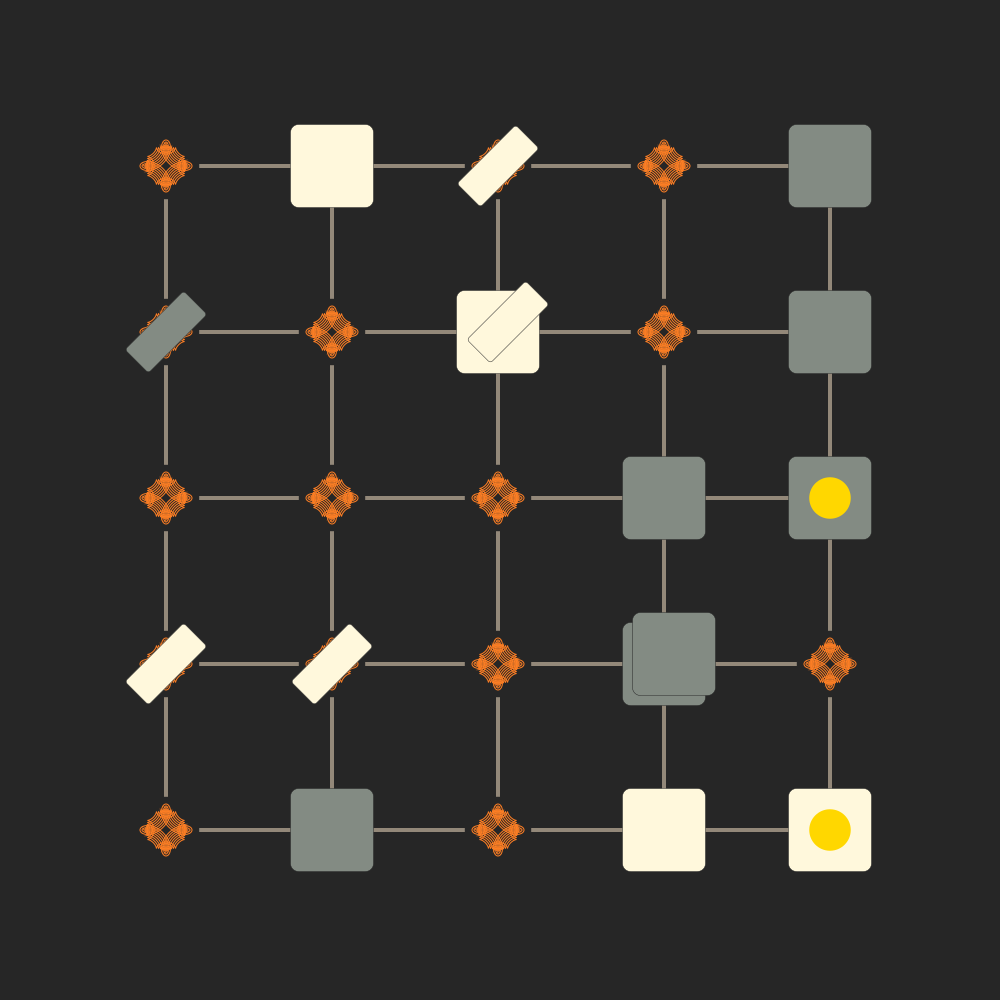

In [22]:
render_board(board)

In [30]:
board2 = board[end:-1:1, :, :]

5×5×43 Array{Union{Nothing, Tuple{Stone,Player}},3}:
[:, :, 1] =
 (flat, black)   (flat, black)   (cap, black)   nothing         (cap, white)
 nothing         nothing         (flat, black)  (flat, black)   (flat, white)
 (stand, white)  (flat, white)   nothing        nothing         nothing
 (flat, white)   nothing         nothing        (stand, white)  (flat, black)
 nothing         (stand, black)  nothing        (stand, white)  nothing

[:, :, 2] =
 nothing  nothing         nothing  nothing        nothing
 nothing  nothing         nothing  (flat, black)  nothing
 nothing  (stand, white)  nothing  nothing        nothing
 nothing  nothing         nothing  nothing        nothing
 nothing  nothing         nothing  nothing        nothing

[:, :, 3] =
 nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing

...

[:, :, 41] 

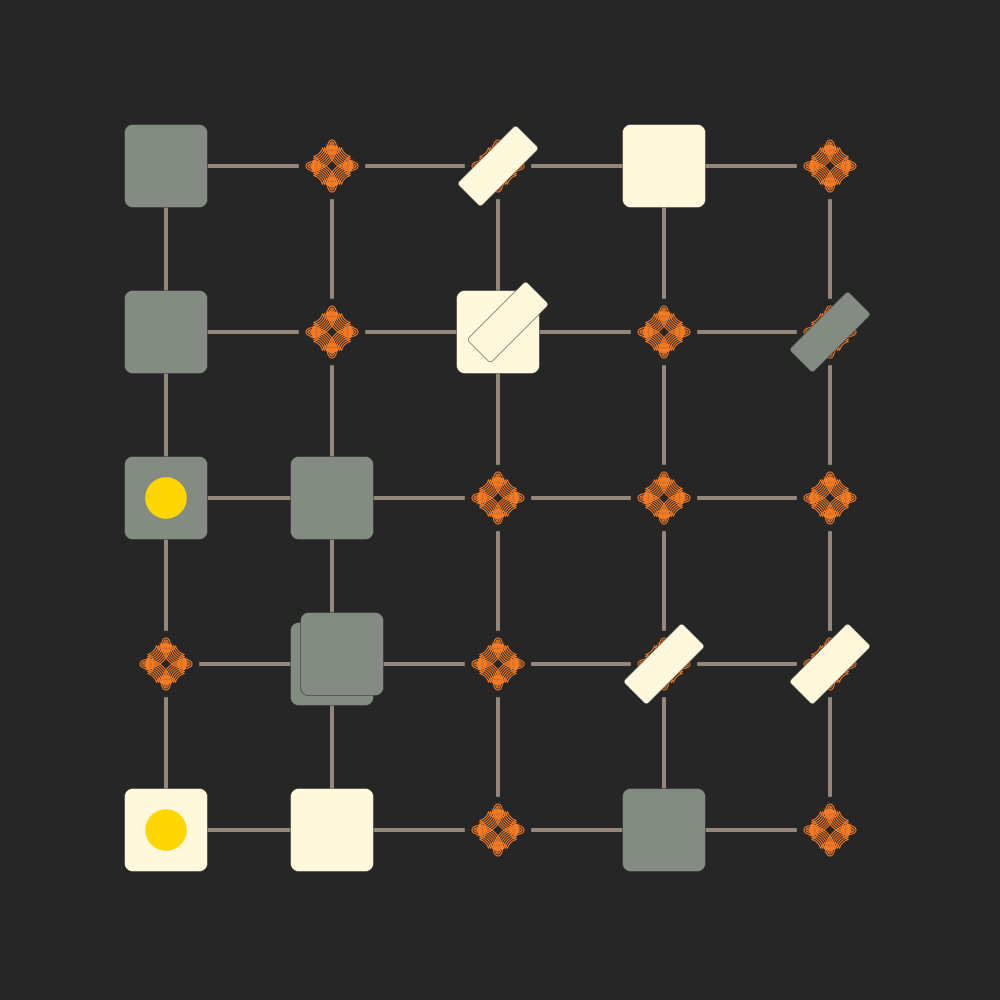

In [31]:
render_board(board2)

In [13]:
length(replay_buffer)

32

In [14]:
batch = rand(replay_buffer, hparams["train_batch_size"])
states, players, probs, possible_actions, values = getindex.(batch, 1), getindex.(batch, 2), getindex.(batch, 3), getindex.(batch, 4), getindex.(batch, 5)
states = Flux.batch(board_to_enc.(decompress_board.(states)))
players = Flux.onehotbatch(players, instances(Player))
inputs = vcat(players, states) |> gpu
probs = convert.(Float, Flux.batch(map(x -> expand_action_probs(x...), zip(possible_actions, probs)))) |> gpu
values = Flux.batch(values) |> gpu

nothing

In [16]:
Flux.gradient(ps) do
    logits_net, values_net = model(inputs)
    loss_values = Flux.Losses.mse(values_net, values)
    loss_probs = Flux.Losses.logitcrossentropy(logits_net, probs)
    loss_total = loss_values + loss_probs
    loss_total
end

Grads(...)

In [8]:
x = rand(10)
y = rand(10)

z = x .+ y

10-element Array{Float64,1}:
 1.6579818416426264
 1.6629451766982248
 0.7449922362182373
 0.32933932145202527
 1.1471362099428106
 0.753300593009185
 0.43833787316868467
 1.2309179623659552
 0.3156955037301994
 1.6218474362676965

In [19]:
rest

Base.Iterators.Rest{Array{Int64,1},Int64}([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 2)

In [38]:
batch = rand(replay_buffer, 16)
states, players, probs, values = gpu.((getindex.(batch, 1), getindex.(batch, 2), getindex.(batch, 3), getindex.(batch, 4)))
states .= board_to_enc.(decompress_board.(states))


16-element Array{Player,1}:
 black::Player = 0x01
 black::Player = 0x01
 black::Player = 0x01
 black::Player = 0x01
 white::Player = 0x00
 black::Player = 0x01
 black::Player = 0x01
 black::Player = 0x01
 white::Player = 0x00
 black::Player = 0x01
 black::Player = 0x01
 white::Player = 0x00
 black::Player = 0x01
 white::Player = 0x00
 black::Player = 0x01
 white::Player = 0x00

In [42]:
sum(states[10])

27